In [3]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from keyword_fetcher import KeywordFetcher
from data_parser import DataParser

In [1]:
TERM_PATH = "../data/frequent_terms.csv"
BIGRAM_PATH = "../data/frequent_bigrams.csv"
TRIGRAM_PATH = "../data/frequent_trigrams.csv"
US_DAILY_PATH = "../data/covid19-in-usa/us_covid19_daily.csv"
STATES_DAILY_PATH = "../data/covid19-in-usa/us_states_covid19_daily.csv"
REGION_LIST_PATH = "../data/abbr-list.csv"
KW_30_US_PATH = "../data/trends/keywords_30_US.csv"
KW_90_US_PATH = "../data/trends/keywords_90_US.csv"
KW_150_US_PATH = "../data/trends/keywords_150_US.csv"
KW_150_10STATES_PATH = "../data/trends/keywords_150_10states.csv"

### Generate Keyword list

In [6]:
kf = KeywordFetcher("../data/frequent_terms.csv", "../data/frequent_bigrams.csv", "../data/frequent_trigrams.csv")
kw = kf.generate_keyword_list(num_features=10)

In [7]:
kw

,keyword,count
0,coronavirus,28120854
1,covid19,8630451
2,covid,8171888
3,19,7903151
4,nan,3888201
5,people,2645140
6,via,2321653
7,china,2225140
8,amp,2143277
9,trump,2038513


## Fetch Google trends result

In [9]:
# result_us = kf.fetch_trends(kw, "2020-01-21", "2020-05-01", 'US', "../data/trends/keywords_30_US.csv")
result_us = pd.read_csv('../data/trends/keywords_30_US.csv')

In [10]:
result_us.head(1)

,date,coronavirus,covid19,covid,19,nan,people,via,china,amp,...,due coronavirus,novel coronavirus,new york,covid 19 pandemic,coronavirus covid 19,covid 19 cases,covid 19 crisis,coronavirus death toll,due covid 19,bbc news coronavirus
0,2020-01-21,2,0,0,9,84,54,95,39,88,...,0,20,63,0,0,0,0,0,0,0


In [12]:
region_list = list(pd.read_csv(REGION_LIST_PATH)["####"])

In [ ]:
for region in region_list:
    kf.fetch_trends(kw, "2020-01-21", "2020-05-01", 'US-'+region, "../data/trends/keywords_30_US-{}.csv".format(region))

## Parse keyword and patient data

In [5]:
parser = DataParser(keywords_path=KW_150_US_PATH, cases_path=US_DAILY_PATH, 
                    start_date="20200121",
                    avg_date=1)
d_avg = parser.process_labels()
train_matrix = parser.process_data_sample(label_array=d_avg)

In [6]:
train_matrix

array([[0.02, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.04, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.28, 0.41, 0.73, ..., 0.3 , 0.15, 0.74],
       [0.27, 0.41, 0.69, ..., 0.32, 0.13, 0.8 ],
       [0.25, 0.39, 0.68, ..., 0.28, 0.15, 0.78]])

In [135]:
X_train, X_test, y_train, y_test = train_test_split(train_matrix[train_matrix.shape[0]-d_avg.shape[0]:], 
                                                    d_avg, test_size=0.2, shuffle=True) 

In [136]:
print("train set shape: {}".format(X_train.shape))
print("test set shape: {}".format(X_test.shape))

train set shape: (80, 27)
test set shape: (21, 27)


## Train models

Mean Standard Error: 3102.710586164999
Train set score: 0.8888331608073382
Test set score: 0.9036601085923149


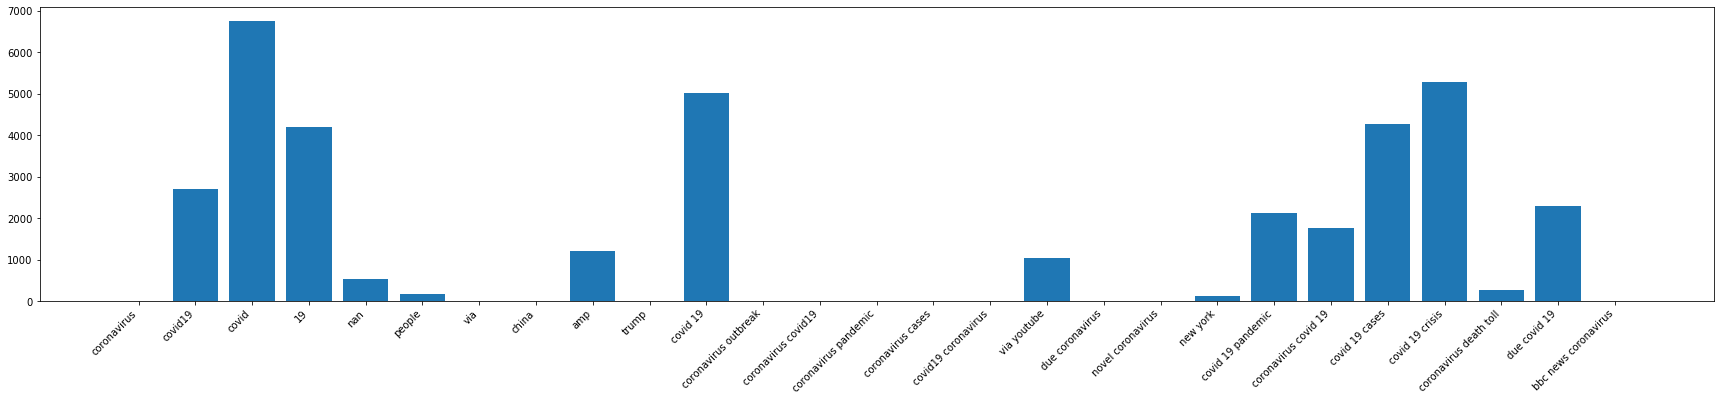

In [137]:
## Elastic Net
#########################################################
EN_reg = ElasticNet(alpha=1,l1_ratio=.9,max_iter=30000, positive=True)
EN_reg.fit(X_train,y_train)

pred_ELN = EN_reg.predict(X_test)
diff = y_test-pred_ELN
print("Mean Standard Error: {}".format(np.mean(abs(diff)) ))
print("Train set score: {}".format(EN_reg.score(X_train,y_train)))
print("Test set score: {}".format(EN_reg.score(X_test,y_test)))

fig, ax = plt.subplots(figsize=(30, 6))
ax.bar(parser.keywords.columns[1:], EN_reg.coef_)
fig.autofmt_xdate(rotation=45)

In [138]:
## MLP
#########################################################
MLP_regressor = MLPRegressor(hidden_layer_sizes=(20,10,5), activation='relu', solver='adam',
                             alpha=1, learning_rate_init=0.01, max_iter=30000, n_iter_no_change=100)
MLP_regressor.fit(X_train,y_train)

pred_MLP = MLP_regressor.predict(X_test)
diff = y_test-pred_MLP
print(np.mean(abs(diff)))
print(MLP_regressor.score(X_train,y_train))
print(MLP_regressor.score(X_test,y_test))

3046.459470644966
0.9998809090006182
0.8288847475100798


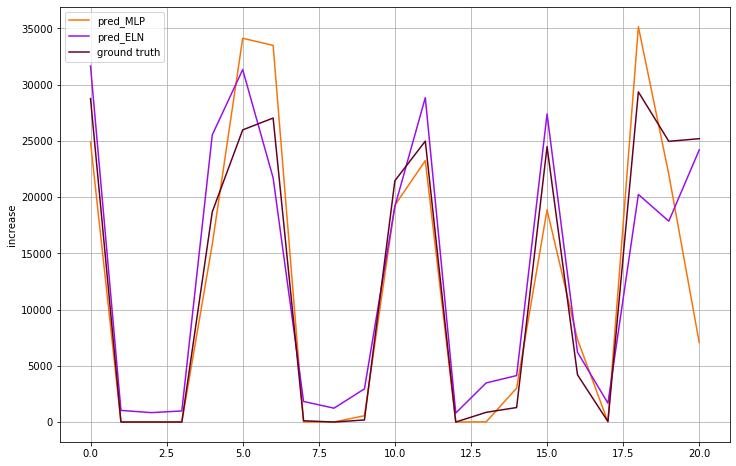

In [139]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
ax1.plot(pred_MLP, 'xkcd:orange')
ax1.plot(pred_ELN, 'xkcd:violet')
ax1.plot(y_test, 'xkcd:maroon')
# ax1.set_ylim([0, 40000])
ax1.set_ylabel('increase')
ax1.legend(['pred_MLP','pred_ELN','ground truth'])
ax1.grid()
# ax1.set_title('new increase pred in 4/19-5/2')